# **Appendix: Data Leakage Analysis & Variable Selection**

## **1. Objective**
The objective of this supplementary notebook is to investigate the impact of **Data Leakage** caused by post-loan variables in the Lending Club dataset. 

In credit default prediction, variables that are generated *after* the loan issuance (e.g., "last_fico_range_high", "last_fico_range_low") contain future information that is unavailable at the time of prediction. Including such variables leads to artificially inflated model performance, rendering the model useless for real-world application.

This experiment demonstrates:
1. The unrealistically high performance (AUC) when these leakage variables are included.
2. The dominance of these variables in Feature Importance, proving they "give away" the answer.

## **2. Preprocessing with ("last_fico_range_high", "last_fico_range_low")**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
loan_data_cleaned = pd.read_csv("loan_data_cleaned.csv")

### **2.1. Train-Test split**

In [2]:
df = loan_data_cleaned.copy()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder


loan_data_cleaned['issue_d_dt'] = pd.to_datetime(loan_data_cleaned['issue_d'], format='%b-%Y')


# Financial Crisis Period
crisis_start = '2007-12-01'
crisis_end = '2009-06-30'

mask_crisis = (loan_data_cleaned['issue_d_dt'] >= crisis_start) & (loan_data_cleaned['issue_d_dt'] <= crisis_end)

df_crisis = loan_data_cleaned[mask_crisis].copy()   # Crisis
df_normal = loan_data_cleaned[~mask_crisis].copy()  # Normal Period

# 1. Feature / Target
feature_drop = ['loan_status', 'target', 'issue_d', 'issue_d_dt']
X_normal = df_normal.drop(feature_drop, axis=1)
Y_normal = df_normal['target']
X_crisis_raw = df_crisis.drop(feature_drop, axis=1)
Y_crisis = df_crisis['target']

# 2. Data Split (Normal Period)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_normal, Y_normal, test_size=0.2, random_state=42, stratify=Y_normal)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# 3. Preprocessing
num_cols = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

### **2.2 Scaling(StandardScaler)**

In [4]:
from sklearn.preprocessing import StandardScaler

num_cols = X_normal.select_dtypes(include =['int', 'float']).columns.tolist()

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols]   = scaler.transform(X_val[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])
X_crisis = X_crisis_raw.copy()
X_crisis[num_cols] = scaler.transform(X_crisis[num_cols])

### **2.3 Metrics**

In [5]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix
from scipy.stats import ks_2samp

def calculate_psi(expected, actual, buckets=10):
    def sub_psi(e_perc, a_perc):
        if a_perc == 0: a_perc = 0.0001
        if e_perc == 0: e_perc = 0.0001
        return (e_perc - a_perc) * np.log(e_perc / a_perc)

    def scale_range(input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    breakpoints = np.stack([np.percentile(expected, b) for b in breakpoints])
    
    expected_percents = np.histogram(expected, breakpoints)[0] / len(expected)
    actual_percents = np.histogram(actual, breakpoints)[0] / len(actual)

    psi_value = np.sum([sub_psi(expected_percents[i], actual_percents[i]) for i in range(len(expected_percents))])
    return psi_value

def weighted_accuracy(confusion):
    M = confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k] /= (M[k].sum() + 1e-8)
    
    acc = M.diagonal().sum() / M.shape[0] 
    return acc

def calculate_evaluation_metrics(y_true, y_prob, y_pred, sample_weights=None, X_train_prob=None, X_test_prob=None):
    
    # 1. AUC
    auc = roc_auc_score(y_true, y_prob)
    
    # 2. Weighted Accuracy
    cm = confusion_matrix(y_true, y_pred, sample_weight=sample_weights)
    w_acc = weighted_accuracy(cm)
    
    # 3. KS Statistic
    prob_pos = y_prob[y_true == 1]
    prob_neg = y_prob[y_true == 0]
    ks_stat, p_value = ks_2samp(prob_pos, prob_neg)
    
    # 4. F1-score
    f1 = f1_score(y_true, y_pred)
    
    # 5. Recall
    rec = recall_score(y_true, y_pred)
    
    # 6. PSI (Population Stability Index)
    psi_val = None
    if X_train_prob is not None and X_test_prob is not None:
        psi_val = calculate_psi(X_train_prob, X_test_prob)

    return {
        "AUC": auc,
        "Weighted Accuracy": w_acc,
        "KS Statistic": ks_stat,
        "PSI": psi_val,
        "F1 Score": f1,
        "Recall": rec
    }

## **3.XGboost**

### Data Preparation

In [6]:
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

X_train_xgb = X_train.copy()
X_val_xgb   = X_val.copy()
X_test_xgb  = X_test.copy()
X_crisis_xgb = X_crisis.copy()

for col in cat_cols:
    X_train_xgb[col] = X_train_xgb[col].astype('category')
    X_val_xgb[col]   = X_val_xgb[col].astype('category')
    X_test_xgb[col]  = X_test_xgb[col].astype('category')
    X_crisis_xgb[col] = X_crisis_xgb[col].astype('category')


In [7]:
# Optuna Tuning 

best_xgb_auc = 0  

def objective_xgb_save(trial):
    global best_xgb_auc
    
    # Parameter range
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10), #class imbalance
        
        # fixed value
        'random_state': 42,
        'device': 'cuda',      # GPU
        'early_stopping_rounds': 50,
        'enable_categorical': True 
    }
    
    model = XGBClassifier(**params)
    
    # Model training
    model.fit(
        X_train_xgb, Y_train,
        eval_set=[(X_val_xgb, Y_val)],
        verbose=False
    )
    
    # Validation AUC
    val_prob = model.predict_proba(X_val_xgb, iteration_range=(0, model.best_iteration + 1))[:, 1]
    current_auc = roc_auc_score(Y_val, val_prob)
    
    # Saving best model
    if current_auc > best_xgb_auc:
        best_xgb_auc = current_auc
        model.save_model("best_xgb_model.json")
        
    return current_auc

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb_save, n_trials=20)

print(f"Best AUC: {best_xgb_auc:.4f} (Saved to best_xgb_model.json)")

[I 2025-12-09 16:14:49,113] A new study created in memory with name: no-name-9ef82846-1dce-4e74-90c5-f52d4cdb7668
c:\Users\Sehong\anaconda3\envs\torch251\Lib\site-packages\xgboost\core.py:774: UserWarning: [16:14:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-12-09 16:14:56,110] Trial 0 finished with value: 0.9471411768583873 and parameters: {'n_estimators': 661, 'max_depth': 4, 'learning_rate': 0.14066043666490408, 'subsample': 0.7299934671514688, 'scale_pos_weight': 3.5179474698771287}. Best is trial 0 with value: 0.9471411768583873.
[I 2

Best AUC: 0.9479 (Saved to best_xgb_model.json)


 Found Optimal Threshold for Normal: 0.50 (Max F1: 0.7741)
 Found Optimal Threshold for Crisis: 0.32 (Max F1: 0.3230)


,AUC,PSI,KS Statistic,F1 Score,Recall,Weighted Accuracy
Normal Period (Opt),0.947128,0.000072,0.772185,0.774060,0.820021,0.870262
Crisis Period (Opt),0.716523,0.642091,0.324329,0.323029,0.432712,0.642491


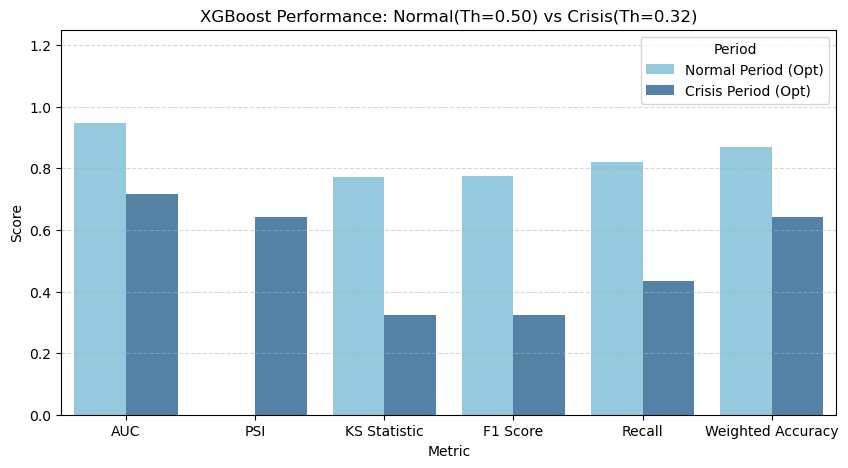

In [8]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# ---------------------------------------------------------
# 2. Load Saved Model
# ---------------------------------------------------------
loaded_model = xgb.Booster()
loaded_model.load_model("best_xgb_model.json")

# ---------------------------------------------------------
# 3. Predict Probabilities
# ---------------------------------------------------------

dtrain = xgb.DMatrix(X_train_xgb, enable_categorical=True)
dtest = xgb.DMatrix(X_test_xgb, enable_categorical=True)
dcrisis = xgb.DMatrix(X_crisis_xgb, enable_categorical=True)

# Get probabilities
prob_train = loaded_model.predict(dtrain)
prob_normal = loaded_model.predict(dtest)
prob_crisis = loaded_model.predict(dcrisis)

# ---------------------------------------------------------
# 4. Find Optimal Thresholds (Normal & Crisis)
# ---------------------------------------------------------
thresholds = np.arange(0.01, 1.00, 0.01)

# (1) Optimization for Normal Period
best_th_normal = 0.5
best_f1_normal = 0

for th in thresholds:
    current_pred = (prob_normal >= th).astype(int)
    current_f1 = f1_score(Y_test, current_pred)
    if current_f1 > best_f1_normal:
        best_f1_normal = current_f1
        best_th_normal = th

print(f" Found Optimal Threshold for Normal: {best_th_normal:.2f} (Max F1: {best_f1_normal:.4f})")

# (2) Optimization for Crisis Period
best_th_crisis = 0.5
best_f1_crisis = 0

for th in thresholds:
    current_pred = (prob_crisis >= th).astype(int)
    current_f1 = f1_score(Y_crisis, current_pred)
    if current_f1 > best_f1_crisis:
        best_f1_crisis = current_f1
        best_th_crisis = th

print(f" Found Optimal Threshold for Crisis: {best_th_crisis:.2f} (Max F1: {best_f1_crisis:.4f})")

# ---------------------------------------------------------
# 5. Generate Final Predictions (With Optimized Thresholds)
# ---------------------------------------------------------
# Normal Period: Apply optimized threshold
pred_normal_opt = (prob_normal >= best_th_normal).astype(int)

# Crisis Period: Apply optimized threshold
pred_crisis_opt = (prob_crisis >= best_th_crisis).astype(int)

# ---------------------------------------------------------
# 6. Calculate Metrics
# ---------------------------------------------------------

# Normal Evaluation (Optimized)
metrics_normal = calculate_evaluation_metrics(
    y_true=Y_test, y_prob=prob_normal, y_pred=pred_normal_opt, 
    X_train_prob=prob_train, X_test_prob=prob_normal
)

# Crisis Evaluation (Optimized)
metrics_crisis = calculate_evaluation_metrics(
    y_true=Y_crisis, y_prob=prob_crisis, y_pred=pred_crisis_opt, 
    X_train_prob=prob_train, X_test_prob=prob_crisis
)

# Organize Results
df_xgb_result = pd.DataFrame([metrics_normal, metrics_crisis], 
                             index=['Normal Period (Opt)', 'Crisis Period (Opt)'])
cols = ['AUC', 'PSI', 'KS Statistic', 'F1 Score', 'Recall', 'Weighted Accuracy']

display(df_xgb_result[cols])

# ---------------------------------------------------------
# 7. Visualization
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
df_plot = df_xgb_result[cols].reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Set Color Palette (Blue for XGBoost)
sns.barplot(data=df_plot, x='Metric', y='Score', hue='index', palette=['skyblue', 'steelblue'])

plt.title(f"XGBoost Performance: Normal(Th={best_th_normal:.2f}) vs Crisis(Th={best_th_crisis:.2f})")
plt.ylim(0, 1.25) # Adjust Y-axis for potential high PSI
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## **4. Lightgbm**

In [9]:
import lightgbm as lgb
from lightgbm import LGBMClassifier

cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

X_train_lgb = X_train.copy()
X_val_lgb   = X_val.copy()
X_test_lgb  = X_test.copy()
X_crisis_lgb = X_crisis.copy()

X_train_lgb[cat_cols] = X_train_lgb[cat_cols].astype('category')
X_val_lgb[cat_cols] =X_val_lgb[cat_cols].astype('category')
X_test_lgb[cat_cols] = X_test_lgb[cat_cols].astype('category')
X_crisis_lgb[cat_cols] =X_crisis_lgb[cat_cols].astype('category')

In [10]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

# 1. Optuna Tuning 
best_lgb_auc = 0  

def objective_lgb_save(trial):
    global best_lgb_auc
    
    # Parameter Range
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 30, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 5),
        
        'random_state': 42,
        'metric': 'auc',
        'verbosity': -1,          
        'n_jobs': -1,
        'min_data_in_bin': 1,     
        'min_data_in_leaf': 20    
    }
    
    model = LGBMClassifier(**params)
    
    # Training
    model.fit(
    X_train_lgb, Y_train,
    eval_set=[(X_val_lgb, Y_val)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(0) 
    ]
)
    
    
    val_pred = model.predict_proba(X_val_lgb)[:, 1]
    auc = roc_auc_score(Y_val, val_pred)
    
    # Saving best model
    if auc > best_lgb_auc:
        best_lgb_auc = auc
        model.booster_.save_model("best_lgb_model.txt") 
        
    return auc

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb_save, n_trials=20)

print(f"Best AUC: {best_lgb_auc:.4f} (Saved to best_lgb_model.txt)")

[I 2025-12-09 16:21:42,633] A new study created in memory with name: no-name-adc5d6eb-7ce1-440b-b906-f061463e3d79


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[116]	valid_0's auc: 0.948419


[I 2025-12-09 16:22:00,499] Trial 0 finished with value: 0.9484188010296466 and parameters: {'n_estimators': 1763, 'learning_rate': 0.1721124875689443, 'num_leaves': 128, 'max_depth': 7, 'scale_pos_weight': 1.9084391103925626}. Best is trial 0 with value: 0.9484188010296466.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[120]	valid_0's auc: 0.948169


[I 2025-12-09 16:22:34,493] Trial 1 finished with value: 0.9481690078148505 and parameters: {'n_estimators': 1632, 'learning_rate': 0.1140608116229232, 'num_leaves': 150, 'max_depth': 13, 'scale_pos_weight': 3.2539020323967094}. Best is trial 0 with value: 0.9484188010296466.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1032]	valid_0's auc: 0.948573


[I 2025-12-09 16:24:36,436] Trial 2 finished with value: 0.9485726830659411 and parameters: {'n_estimators': 1032, 'learning_rate': 0.012466009776013483, 'num_leaves': 106, 'max_depth': 6, 'scale_pos_weight': 3.260981577344657}. Best is trial 2 with value: 0.9485726830659411.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.948313


[I 2025-12-09 16:24:49,984] Trial 3 finished with value: 0.9483134681587437 and parameters: {'n_estimators': 707, 'learning_rate': 0.2737881538438759, 'num_leaves': 38, 'max_depth': 6, 'scale_pos_weight': 1.3119143170558627}. Best is trial 2 with value: 0.9485726830659411.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[105]	valid_0's auc: 0.947648


[I 2025-12-09 16:25:04,133] Trial 4 finished with value: 0.9476481430848009 and parameters: {'n_estimators': 917, 'learning_rate': 0.2977573191376456, 'num_leaves': 120, 'max_depth': 5, 'scale_pos_weight': 3.7236826852655316}. Best is trial 2 with value: 0.9485726830659411.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[78]	valid_0's auc: 0.948233


[I 2025-12-09 16:25:25,709] Trial 5 finished with value: 0.9482329550530075 and parameters: {'n_estimators': 1368, 'learning_rate': 0.18267716176911508, 'num_leaves': 67, 'max_depth': 11, 'scale_pos_weight': 1.9027231248342495}. Best is trial 2 with value: 0.9485726830659411.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[220]	valid_0's auc: 0.948659


[I 2025-12-09 16:25:55,184] Trial 6 finished with value: 0.9486587390716834 and parameters: {'n_estimators': 1793, 'learning_rate': 0.11085060118155174, 'num_leaves': 141, 'max_depth': 6, 'scale_pos_weight': 3.446172180685063}. Best is trial 6 with value: 0.9486587390716834.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[59]	valid_0's auc: 0.947959


[I 2025-12-09 16:26:16,700] Trial 7 finished with value: 0.9479587682546854 and parameters: {'n_estimators': 1308, 'learning_rate': 0.20476845499482854, 'num_leaves': 77, 'max_depth': 11, 'scale_pos_weight': 1.3113083286602478}. Best is trial 6 with value: 0.9486587390716834.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[28]	valid_0's auc: 0.946535


[I 2025-12-09 16:26:40,457] Trial 8 finished with value: 0.9465349401393678 and parameters: {'n_estimators': 1813, 'learning_rate': 0.29420412540952784, 'num_leaves': 142, 'max_depth': 14, 'scale_pos_weight': 3.16279605169376}. Best is trial 6 with value: 0.9486587390716834.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[369]	valid_0's auc: 0.949016


[I 2025-12-09 16:27:26,676] Trial 9 finished with value: 0.9490162391446116 and parameters: {'n_estimators': 1869, 'learning_rate': 0.06315574991847367, 'num_leaves': 122, 'max_depth': 6, 'scale_pos_weight': 2.0987998643237606}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[891]	valid_0's auc: 0.948583


[I 2025-12-09 16:29:37,205] Trial 10 finished with value: 0.9485832443102932 and parameters: {'n_estimators': 1477, 'learning_rate': 0.017652994170100612, 'num_leaves': 97, 'max_depth': 9, 'scale_pos_weight': 4.917992051743708}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	valid_0's auc: 0.948676


[I 2025-12-09 16:29:59,594] Trial 11 finished with value: 0.9486761687266223 and parameters: {'n_estimators': 1954, 'learning_rate': 0.09555365444700949, 'num_leaves': 124, 'max_depth': 8, 'scale_pos_weight': 2.4015264632574187}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[244]	valid_0's auc: 0.948896


[I 2025-12-09 16:30:31,801] Trial 12 finished with value: 0.9488962196672412 and parameters: {'n_estimators': 1922, 'learning_rate': 0.07106685022281829, 'num_leaves': 118, 'max_depth': 8, 'scale_pos_weight': 2.173914408152564}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[319]	valid_0's auc: 0.948886


[I 2025-12-09 16:31:14,948] Trial 13 finished with value: 0.9488860528709748 and parameters: {'n_estimators': 1544, 'learning_rate': 0.06205362956556068, 'num_leaves': 108, 'max_depth': 9, 'scale_pos_weight': 2.407800577431374}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[302]	valid_0's auc: 0.948954


[I 2025-12-09 16:31:49,337] Trial 14 finished with value: 0.9489535345924582 and parameters: {'n_estimators': 1995, 'learning_rate': 0.06034545709865345, 'num_leaves': 82, 'max_depth': 8, 'scale_pos_weight': 2.4326030155162073}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[504]	valid_0's auc: 0.948557


[I 2025-12-09 16:32:18,897] Trial 15 finished with value: 0.9485569419534494 and parameters: {'n_estimators': 518, 'learning_rate': 0.048004187650509046, 'num_leaves': 80, 'max_depth': 5, 'scale_pos_weight': 4.199630050430109}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[101]	valid_0's auc: 0.948401


[I 2025-12-09 16:32:33,764] Trial 16 finished with value: 0.9484012961661826 and parameters: {'n_estimators': 1092, 'learning_rate': 0.13906602561789888, 'num_leaves': 57, 'max_depth': 10, 'scale_pos_weight': 2.710210246632282}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[94]	valid_0's auc: 0.948282


[I 2025-12-09 16:32:48,810] Trial 17 finished with value: 0.9482815702241933 and parameters: {'n_estimators': 2000, 'learning_rate': 0.21954898134340056, 'num_leaves': 91, 'max_depth': 7, 'scale_pos_weight': 1.6746366601584934}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[438]	valid_0's auc: 0.948961


[I 2025-12-09 16:33:30,801] Trial 18 finished with value: 0.9489609427908117 and parameters: {'n_estimators': 1672, 'learning_rate': 0.043717149248308794, 'num_leaves': 48, 'max_depth': 8, 'scale_pos_weight': 2.686409607169642}. Best is trial 9 with value: 0.9490162391446116.


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[672]	valid_0's auc: 0.948971


[I 2025-12-09 16:34:31,770] Trial 19 finished with value: 0.9489711851129384 and parameters: {'n_estimators': 1630, 'learning_rate': 0.036544889726607785, 'num_leaves': 42, 'max_depth': 12, 'scale_pos_weight': 2.815058831005127}. Best is trial 9 with value: 0.9490162391446116.


Best AUC: 0.9490 (Saved to best_lgb_model.txt)


Found Optimal Threshold for Normal: 0.59 (Max F1: 0.7750)
Found Optimal Threshold for Crisis: 0.40 (Max F1: 0.3689)


,AUC,PSI,KS Statistic,F1 Score,Recall,Weighted Accuracy
Normal Period (Opt),0.948079,0.000045,0.773715,0.774982,0.815739,0.869357
Crisis Period (Opt),0.742458,0.690329,0.380148,0.368948,0.457557,0.668165


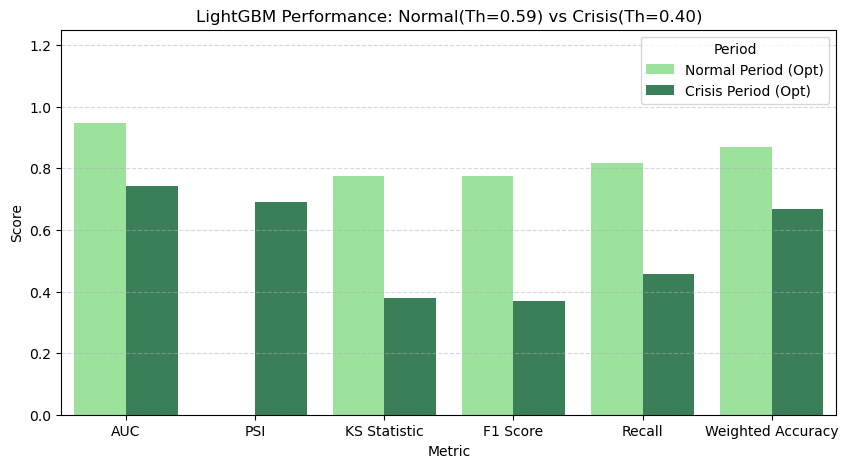

In [11]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

# ---------------------------------------------------------
# 2. Load Saved Model
# ---------------------------------------------------------
loaded_model = lgb.Booster(model_file="best_lgb_model.txt")

# ---------------------------------------------------------
# 3. Predict Probabilities
# ---------------------------------------------------------
# Get probabilities for Train (PSI baseline), Test (Normal), and Crisis data
prob_train = loaded_model.predict(X_train_lgb)
prob_normal = loaded_model.predict(X_test_lgb)
prob_crisis = loaded_model.predict(X_crisis_lgb)

# ---------------------------------------------------------
# 4. Find Optimal Thresholds (Normal & Crisis)
# ---------------------------------------------------------
thresholds = np.arange(0.01, 1.00, 0.01)

# (1) Optimization for Normal Period
best_th_normal = 0.5
best_f1_normal = 0

for th in thresholds:
    current_pred = (prob_normal >= th).astype(int)
    current_f1 = f1_score(Y_test, current_pred)
    if current_f1 > best_f1_normal:
        best_f1_normal = current_f1
        best_th_normal = th

print(f"Found Optimal Threshold for Normal: {best_th_normal:.2f} (Max F1: {best_f1_normal:.4f})")

# (2) Optimization for Crisis Period
best_th_crisis = 0.5
best_f1_crisis = 0

for th in thresholds:
    current_pred = (prob_crisis >= th).astype(int)
    current_f1 = f1_score(Y_crisis, current_pred)
    if current_f1 > best_f1_crisis:
        best_f1_crisis = current_f1
        best_th_crisis = th

print(f"Found Optimal Threshold for Crisis: {best_th_crisis:.2f} (Max F1: {best_f1_crisis:.4f})")

# ---------------------------------------------------------
# 5. Generate Final Predictions (With Optimized Thresholds)
# ---------------------------------------------------------
# Normal Period: Apply optimized threshold
pred_normal_opt = (prob_normal >= best_th_normal).astype(int)

# Crisis Period: Apply optimized threshold
pred_crisis_opt = (prob_crisis >= best_th_crisis).astype(int)

# ---------------------------------------------------------
# 6. Calculate Metrics
# ---------------------------------------------------------

# Normal Evaluation (Optimized)
metrics_normal = calculate_evaluation_metrics(
    y_true=Y_test, y_prob=prob_normal, y_pred=pred_normal_opt, 
    X_train_prob=prob_train, X_test_prob=prob_normal
)

# Crisis Evaluation (Optimized)
metrics_crisis = calculate_evaluation_metrics(
    y_true=Y_crisis, y_prob=prob_crisis, y_pred=pred_crisis_opt, 
    X_train_prob=prob_train, X_test_prob=prob_crisis
)

# Organize Results
df_lgb_result = pd.DataFrame([metrics_normal, metrics_crisis], 
                             index=['Normal Period (Opt)', 'Crisis Period (Opt)'])
cols = ['AUC', 'PSI', 'KS Statistic', 'F1 Score', 'Recall', 'Weighted Accuracy']

display(df_lgb_result[cols])

# ---------------------------------------------------------
# 7. Visualization
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
df_plot = df_lgb_result[cols].reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Set Color Palette (Green for LightGBM)
sns.barplot(data=df_plot, x='Metric', y='Score', hue='index', palette=['lightgreen', 'seagreen'])

plt.title(f"LightGBM Performance: Normal(Th={best_th_normal:.2f}) vs Crisis(Th={best_th_crisis:.2f})")
plt.ylim(0, 1.25) # Adjust Y-axis for potential high PSI
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## **5. MLP + Embedding**

In [12]:
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as torch_dataset
import numpy as np
import pandas as pd
import optuna
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [13]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# -----------------------------------------------------------
# Copy Data (Preserve Originals)
# -----------------------------------------------------------
X_train_emb  = X_train.copy()
X_val_emb    = X_val.copy()
X_test_emb   = X_test.copy()   # Added
X_crisis_emb = X_crisis.copy() # Added

# Identify categorical and numerical columns
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()

cat_dims = [] 

# -----------------------------------------------------------
# Categorical (Xa) Encoding (LabelEncoding + Unknown Handling)
# -----------------------------------------------------------
for col in cat_cols:
    le = LabelEncoder()
    # Fit and transform based on Train data
    X_train_emb[col] = le.fit_transform(X_train_emb[col].astype(str))
    
    # Create mapping dictionary for Unknown handling
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    unknown_val = len(le.classes_) # Assign a new index for values not seen during training
    
    # Map Val, Test, Crisis using Train-based dictionary (use unknown_val if missing)
    X_val_emb[col]    = X_val_emb[col].astype(str).map(le_dict).fillna(unknown_val).astype(int)
    X_test_emb[col]   = X_test_emb[col].astype(str).map(le_dict).fillna(unknown_val).astype(int)
    X_crisis_emb[col] = X_crisis_emb[col].astype(str).map(le_dict).fillna(unknown_val).astype(int)
    
    # Save dimensions for embedding layer configuration (+1 to include Unknown)
    cat_dims.append(len(le.classes_) + 1)

# -----------------------------------------------------------
# Numerical (Xb) Scaling (StandardScaler)
# -----------------------------------------------------------
scaler = StandardScaler()
# Fit based on Train data
X_train_emb[num_cols] = scaler.fit_transform(X_train_emb[num_cols])

# Apply Transform only to the remaining datasets
X_val_emb[num_cols]    = scaler.transform(X_val_emb[num_cols])
X_test_emb[num_cols]   = scaler.transform(X_test_emb[num_cols])
X_crisis_emb[num_cols] = scaler.transform(X_crisis_emb[num_cols])


# -----------------------------------------------------------
# Calculate Imbalance Weights
# -----------------------------------------------------------
num_pos = Y_train.sum()
num_neg = len(Y_train) - num_pos
# Calculate weight for positive class (useful for BCEWithLogitsLoss)
pos_weight = torch.tensor([num_neg / num_pos]).to(device)

Using Device: cuda:0


In [14]:
class MyDataset(torch_dataset):
    def __init__(self, df, y, cat_cols, num_cols):
        self.xa = torch.tensor(df[cat_cols].values, dtype=torch.long) 
        self.xb = torch.tensor(df[num_cols].values, dtype=torch.float32) # 
        self.y  = torch.tensor(y.values, dtype=torch.float32) 
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.xa[idx], self.xb[idx], self.y[idx]

# Create Datasets
dataset_train = MyDataset(X_train_emb, Y_train, cat_cols, num_cols)
dataset_val   = MyDataset(X_val_emb, Y_val, cat_cols, num_cols)

# DataLoader
loader_train = DataLoader(dataset_train, batch_size=4096, shuffle=True, num_workers=0)
loader_val   = DataLoader(dataset_val, batch_size=4096, shuffle=False, num_workers=0)

In [15]:
class Net(nn.Module):
    def __init__(self, cat_dims, num_features, hidden_units):
        super().__init__()
        
        # 1. Embedding Layers (for Xa)
        self.EbLayer = nn.ModuleList([
            nn.Embedding(dim, min(50, (dim+1)//2)) for dim in cat_dims
        ])
        self.total_emb_dim = sum([emb.embedding_dim for emb in self.EbLayer])
        
        # 2. Input Norm & Linear (Input Dimension = Embedding + Numerical)
        in_dim = self.total_emb_dim + num_features
        self.input_norm = nn.LayerNorm(in_dim)
        
        # 3. Hidden Layers (Modern MLP Style: Linear -> LayerNorm)
        layers = []
        for units in hidden_units:
            layers.append(nn.Linear(in_dim, units))
            layers.append(nn.LayerNorm(units))
            layers.append(nn.GELU()) 
            in_dim = units
            
        # 4. Output Layer
        layers.append(nn.Linear(in_dim, 1))
        self.layers = nn.Sequential(*layers)

    def forward(self, xa, xb):
        # xa: categorical (LongTensor), xb: numerical (FloatTensor)
        
        # Embeddings
        eb_list = []
        for n, layer in enumerate(self.EbLayer):
            eb_list.append(layer(xa[:, n]))
            
        # Concatenate Embeddings + Numerical Features
        feature = torch.cat(eb_list + [xb], dim=1)
        
        # Normalize Input
        feature = self.input_norm(feature)
        
        # Pass through Hidden Layers
        output = self.layers(feature)
        
        return output

In [16]:
def train(model, device, optimizer, dataloader, epoch, criterion):    
    model.train() # set model to training mode
    loss_train = 0
    sample_count = 0
    
    for batch_idx, (Xa, Xb, Y) in enumerate(dataloader):
        Xa, Xb, Y = Xa.to(device), Xb.to(device), Y.to(device)
        
        # Forward pass 
        Yp = model(Xa, Xb).squeeze() 
        
        # Loss calculation
        loss = criterion(Yp, Y)
        
        optimizer.zero_grad() # clear grad
        loss.backward()       # backward pass
                
        optimizer.step()      # update parameters        
        
        loss_train += loss.item() * Xa.size(0)
        sample_count += Xa.size(0)
        
    loss_train /= sample_count
    return loss_train

def test(model, device, dataloader, criterion):
    model.eval() # set model to evaluation mode
    loss_test = 0   
    
    all_targets = []
    all_preds = []
    
    with torch.no_grad(): 
        for batch_idx, (Xa, Xb, Y) in enumerate(dataloader):
            Xa, Xb, Y = Xa.to(device), Xb.to(device), Y.to(device)
            
            Yp = model(Xa, Xb).squeeze()
            
            loss = criterion(Yp, Y)
            loss_test += loss.item() * Xa.size(0)
            
            probs = torch.sigmoid(Yp)
            all_targets.extend(Y.cpu().numpy())
            all_preds.extend(probs.cpu().numpy())
            
    loss_test /= len(dataloader.dataset)
    
    # Calculate AUC
    try:
        auc_score = roc_auc_score(all_targets, all_preds)
    except:
        auc_score = 0.5
        
    return loss_test, auc_score

In [17]:
import torch
import torch.optim as optim
import torch.nn as nn

best_mlp_auc = 0

def objective_mlp_save(trial):
    global best_mlp_auc
    
    # Parameter Range
    n_layers = trial.suggest_int('n_layers', 1, 3)
    hidden_units = [trial.suggest_int(f'units_l{i}', 64, 512) for i in range(n_layers)]
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    
    model = Net(cat_dims, len(num_cols), hidden_units).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
   
    for epoch in range(10):
        train(model, device, optimizer, loader_train, epoch, criterion)
    
    _, val_auc = test(model, device, loader_val, criterion)
    
    if val_auc > best_mlp_auc:
        best_mlp_auc = val_auc
        torch.save(model.state_dict(), "best_mlp_model.pth")
        
    return val_auc

study_mlp = optuna.create_study(direction='maximize')
study_mlp.optimize(objective_mlp_save, n_trials=10)

print(f"Best AUC: {best_mlp_auc:.4f} (Saved to best_mlp_model.pth)")



[I 2025-12-09 16:34:49,667] A new study created in memory with name: no-name-35291c61-65f5-40bf-a98d-3befa641d56c
[I 2025-12-09 16:37:59,043] Trial 0 finished with value: 0.9465422117247678 and parameters: {'n_layers': 1, 'units_l0': 151, 'lr': 0.007565863147207127}. Best is trial 0 with value: 0.9465422117247678.
[I 2025-12-09 16:44:54,947] Trial 1 finished with value: 0.9456730488593248 and parameters: {'n_layers': 2, 'units_l0': 347, 'units_l1': 286, 'lr': 0.0005106534241141387}. Best is trial 0 with value: 0.9465422117247678.
[I 2025-12-09 16:49:17,699] Trial 2 finished with value: 0.9462214508575006 and parameters: {'n_layers': 1, 'units_l0': 493, 'lr': 0.00010722368087432071}. Best is trial 0 with value: 0.9465422117247678.
[I 2025-12-09 16:52:30,959] Trial 3 finished with value: 0.9464502892954293 and parameters: {'n_layers': 1, 'units_l0': 407, 'lr': 0.00011208134999591619}. Best is trial 0 with value: 0.9465422117247678.
[I 2025-12-09 16:55:44,899] Trial 4 finished with value:

Best AUC: 0.9475 (Saved to best_mlp_model.pth)


[MLP] Found Optimal Threshold for Normal: 0.67 (Max F1: 0.7737)
[MLP] Found Optimal Threshold for Crisis: 0.61 (Max F1: 0.3060)


,AUC,PSI,KS Statistic,F1 Score,Recall,Weighted Accuracy
Normal Period (Opt),0.946497,0.000031,0.772106,0.773665,0.835526,0.87460
Crisis Period (Opt),0.705353,0.852114,0.318556,0.306002,0.374741,0.62369


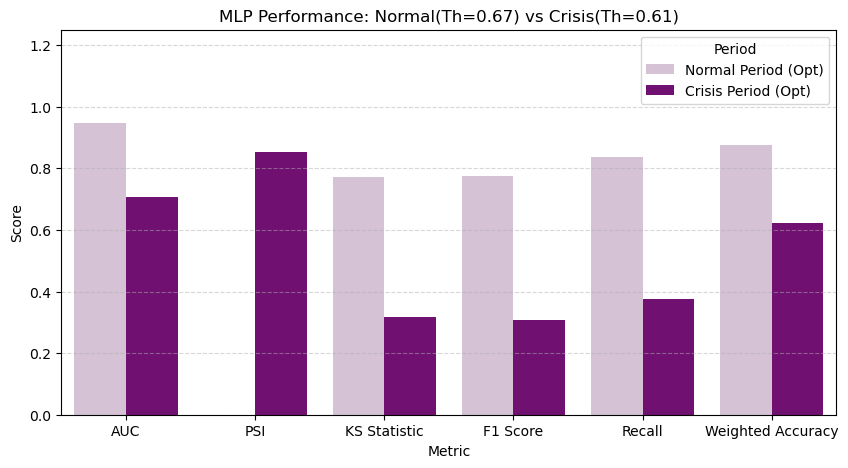

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import torch
from torch.utils.data import DataLoader

# ---------------------------------------------------------
# 1. Model Setup & Weight Loading
# ---------------------------------------------------------
# Restore Best Architecture
best_params = study_mlp.best_params
n_layers = best_params['n_layers']
best_hidden = [best_params[f'units_l{i}'] for i in range(n_layers)]

# Initialize Model
final_mlp = Net(cat_dims, len(num_cols), best_hidden).to(device)

# Load Weights (No Retraining)
final_mlp.load_state_dict(torch.load("best_mlp_model.pth"))

# ---------------------------------------------------------
# 2. Data Preparation (Using MyDataset & Embeddings)
# ---------------------------------------------------------
# Prediction Function (Returns probabilities)
def get_preds(model, loader):
    model.eval()
    probs = []
    with torch.no_grad():
        for xa, xb, _ in loader:
            xa, xb = xa.to(device), xb.to(device)
            # Logits -> Sigmoid -> Probability
            p = torch.sigmoid(model(xa, xb).squeeze()).cpu().numpy()
            probs.append(p)
    return np.concatenate(probs)


# Crisis Dataset/Loader (Using X_crisis_emb)
dataset_crisis = MyDataset(X_crisis_emb, Y_crisis, cat_cols, num_cols)
loader_crisis = DataLoader(dataset_crisis, batch_size=4096, shuffle=False)

# Test (Normal) Dataset/Loader (Using X_test_emb)
dataset_test = MyDataset(X_test_emb, Y_test, cat_cols, num_cols)
loader_test = DataLoader(dataset_test, batch_size=4096, shuffle=False)

# Train Loader (Reuse dataset_train from training step for PSI calculation)
loader_train_eval = DataLoader(dataset_train, batch_size=4096, shuffle=False)

# ---------------------------------------------------------
# 3. Generate Probabilities
# ---------------------------------------------------------
prob_train = get_preds(final_mlp, loader_train_eval)
prob_normal = get_preds(final_mlp, loader_test)
prob_crisis = get_preds(final_mlp, loader_crisis)

# ---------------------------------------------------------
# 4. Find Optimal Thresholds (Dual Optimization)
# ---------------------------------------------------------
thresholds = np.arange(0.01, 1.00, 0.01)

# (1) Optimization for Normal Period
best_th_normal = 0.5
best_f1_normal = 0

for th in thresholds:
    current_pred = (prob_normal >= th).astype(int)
    current_f1 = f1_score(Y_test, current_pred)
    if current_f1 > best_f1_normal:
        best_f1_normal = current_f1
        best_th_normal = th

print(f"[MLP] Found Optimal Threshold for Normal: {best_th_normal:.2f} (Max F1: {best_f1_normal:.4f})")

# (2) Optimization for Crisis Period
best_th_crisis = 0.5
best_f1_crisis = 0

for th in thresholds:
    current_pred = (prob_crisis >= th).astype(int)
    current_f1 = f1_score(Y_crisis, current_pred)
    if current_f1 > best_f1_crisis:
        best_f1_crisis = current_f1
        best_th_crisis = th

print(f"[MLP] Found Optimal Threshold for Crisis: {best_th_crisis:.2f} (Max F1: {best_f1_crisis:.4f})")

# ---------------------------------------------------------
# 5. Apply Thresholds & Calculate Metrics
# ---------------------------------------------------------
# Apply Optimized Thresholds
pred_normal_opt = (prob_normal >= best_th_normal).astype(int)
pred_crisis_opt = (prob_crisis >= best_th_crisis).astype(int)


# Normal Evaluation
metrics_normal = calculate_evaluation_metrics(
    y_true=Y_test, y_prob=prob_normal, y_pred=pred_normal_opt, 
    X_train_prob=prob_train, X_test_prob=prob_normal
)

# Crisis Evaluation
metrics_crisis = calculate_evaluation_metrics(
    y_true=Y_crisis, y_prob=prob_crisis, y_pred=pred_crisis_opt, 
    X_train_prob=prob_train, X_test_prob=prob_crisis
)

# Organize Results
df_mlp_result = pd.DataFrame([metrics_normal, metrics_crisis], 
                             index=['Normal Period (Opt)', 'Crisis Period (Opt)'])
cols = ['AUC', 'PSI', 'KS Statistic', 'F1 Score', 'Recall', 'Weighted Accuracy']

display(df_mlp_result[cols])

# ---------------------------------------------------------
# 6. Visualization
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))
df_plot = df_mlp_result[cols].reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Set Color Palette (Purple for MLP)
sns.barplot(data=df_plot, x='Metric', y='Score', hue='index', palette=['thistle', 'purple'])

plt.title(f"MLP Performance: Normal(Th={best_th_normal:.2f}) vs Crisis(Th={best_th_crisis:.2f})")
plt.ylim(0, 1.25)
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## **6.Deep Table**

In [19]:
import shutil
import optuna
import torch
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models import GANDALFConfig
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')


train_df = X_train.copy()
train_df['target'] = Y_train

val_df = X_val.copy()
val_df['target'] = Y_val

test_df = X_test.copy()
test_df['target'] = Y_test

crisis_df = X_crisis.copy()
crisis_df['target'] =Y_crisis

In [20]:
cat_col_names = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
num_col_names = X_train.select_dtypes(exclude=['object', 'category']).columns.tolist()
# =============================================================================
# DataConfig
# =============================================================================
data_config = DataConfig(
    target=['target'], 
    continuous_cols=num_col_names,
    categorical_cols=cat_col_names,
    continuous_feature_transform="quantile_normal",
    normalize_continuous_features=True,
    
    num_workers=0,
    pin_memory=False
)

# =============================================================================
# [2] OptimizerConfig
# =============================================================================
optimizer_config = OptimizerConfig()

# =============================================================================
# [3] Optuna
# =============================================================================
best_dt_auc = 0

def objective_dt_save(trial):
    global best_dt_auc
    
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    
    trainer_config = TrainerConfig(
        batch_size=1024,
        max_epochs=10,
        accelerator="auto", 
        devices=1 if torch.cuda.is_available() else None,
        checkpoints="valid_loss",
        early_stopping=None,
        progress_bar="none"
    )

    model_config = GANDALFConfig(task="classification", learning_rate=lr)
    
    tabular_model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        optimizer_config=optimizer_config,
        trainer_config=trainer_config,
        suppress_lightning_logger=True 
    )
    
    tabular_model.fit(train=train_df, validation=val_df)
    
    pred_df = tabular_model.predict(val_df)
    
    prob_col = [c for c in pred_df.columns if c.endswith("probability") and "1" in c]
    if not prob_col:
        prob_col = [pred_df.columns[-1]]
        
    auc = roc_auc_score(val_df['target'], pred_df[prob_col[0]])
    
    # Best Model
    if auc > best_dt_auc:
        best_dt_auc = auc
        try: shutil.rmtree("best_deeptable_model") 
        except: pass
        tabular_model.save_model("best_deeptable_model")
        
    return auc

study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective_dt_save, n_trials=5)

print(f"Best AUC: {best_dt_auc:.4f} (Saved to folder 'best_deeptable_model')")

[I 2025-12-09 17:12:39,469] A new study created in memory with name: no-name-b87af003-3e32-4f53-8395-734a7e0b72d0


2025-12-09 17:12:39,507 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:12:39,565 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:12:40,716 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:12:57,183 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:12:58,207 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:12:58,374 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:20:34,707 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:20:34,709 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:20:41,739] Trial 0 finished with value: 0.945932200775416 and parameters: {'learning_rate': 0.008418447381414897}. Best is trial 0 with value: 0.945932200775416.


2025-12-09 17:20:41,760 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:20:41,788 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:20:42,792 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:20:57,844 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:20:58,648 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:20:58,730 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:28:15,480 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:28:15,482 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:28:22,380] Trial 1 finished with value: 0.9488328193569002 and parameters: {'learning_rate': 0.0021240637661230325}. Best is trial 1 with value: 0.9488328193569002.


2025-12-09 17:28:22,401 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:28:22,428 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:28:23,408 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:28:38,264 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:28:39,098 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:28:39,179 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:35:57,355 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:35:57,358 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:36:03,828] Trial 2 finished with value: 0.9481449821818916 and parameters: {'learning_rate': 0.0002124372427054735}. Best is trial 1 with value: 0.9488328193569002.


2025-12-09 17:36:03,851 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:36:03,885 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:36:04,898 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:36:19,697 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:36:20,544 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:36:20,626 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:43:39,295 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:43:39,297 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:43:45,847] Trial 3 finished with value: 0.9480717871512131 and parameters: {'learning_rate': 0.00023078831534117987}. Best is trial 1 with value: 0.9488328193569002.


2025-12-09 17:43:45,872 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

2025-12-09 17:43:45,904 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-12-09 17:43:46,901 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
classification task

2025-12-09 17:44:01,463 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: GANDALFModel

2025-12-09 17:44:02,305 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

2025-12-09 17:44:02,392 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

2025-12-09 17:51:22,157 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-12-09 17:51:22,159 - {pytorch_tabular.tabular_model:1529} - INFO - Loading the best model

[I 2025-12-09 17:51:28,623] Trial 4 finished with value: 0.9481829499521242 and parameters: {'learning_rate': 0.0001930988101710499}. Best is trial 1 with value: 0.9488328193569002.


Best AUC: 0.9488 (Saved to folder 'best_deeptable_model')


2025-12-09 17:51:30,917 - {pytorch_tabular.tabular_model:171} - INFO - Experiment Tracking is turned off

2025-12-09 17:51:30,931 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

[DeepTable] Found Optimal Threshold for Normal: 0.41 (Max F1: 0.7747)
[DeepTable] Found Optimal Threshold for Crisis: 0.22 (Max F1: 0.3068)


,AUC,PSI,KS Statistic,F1 Score,Recall,Weighted Accuracy
Normal Period (Opt),0.947647,0.000062,0.774223,0.774685,0.823613,0.871529
Crisis Period (Opt),0.702595,1.064334,0.303002,0.306773,0.478261,0.641953


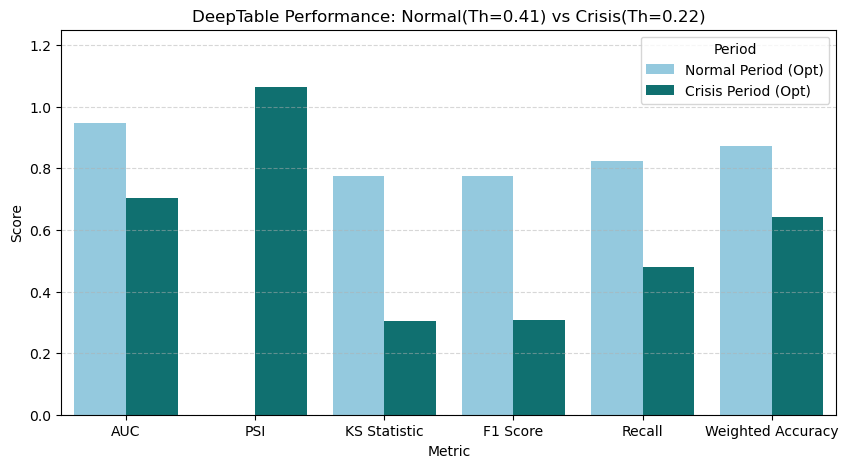

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
from pytorch_tabular import TabularModel

# ---------------------------------------------------------
# 1. Load Saved Model
# ---------------------------------------------------------
# Load the model saved from your Optuna study
loaded_dt = TabularModel.load_model("best_deeptable_model")

# ---------------------------------------------------------
# 2. Extract Probabilities
# ---------------------------------------------------------

# Generate predictions (returns a DataFrame with prediction columns)
pred_train = loaded_dt.predict(train_df)
pred_normal = loaded_dt.predict(test_df)
pred_crisis = loaded_dt.predict(crisis_df)

prob_col_candidates = [c for c in pred_train.columns if c.endswith("probability") and "1" in c]

if prob_col_candidates:
    target_col = prob_col_candidates[0]
else:
    target_col = pred_train.columns[-1]

# Convert to simple numpy arrays for calculation
prob_train = pred_train[target_col].values
prob_normal = pred_normal[target_col].values
prob_crisis = pred_crisis[target_col].values

# ---------------------------------------------------------
# 3. Find Optimal Thresholds (Dual Optimization)
# ---------------------------------------------------------
thresholds = np.arange(0.01, 1.00, 0.01)

# (1) Optimization for Normal Period
best_th_normal = 0.5
best_f1_normal = 0

for th in thresholds:
    current_pred = (prob_normal >= th).astype(int)
    current_f1 = f1_score(Y_test, current_pred)
    if current_f1 > best_f1_normal:
        best_f1_normal = current_f1
        best_th_normal = th

print(f"[DeepTable] Found Optimal Threshold for Normal: {best_th_normal:.2f} (Max F1: {best_f1_normal:.4f})")

# (2) Optimization for Crisis Period
best_th_crisis = 0.5
best_f1_crisis = 0

for th in thresholds:
    current_pred = (prob_crisis >= th).astype(int)
    current_f1 = f1_score(Y_crisis, current_pred)
    if current_f1 > best_f1_crisis:
        best_f1_crisis = current_f1
        best_th_crisis = th

print(f"[DeepTable] Found Optimal Threshold for Crisis: {best_th_crisis:.2f} (Max F1: {best_f1_crisis:.4f})")

# ---------------------------------------------------------
# 4. Generate Final Predictions (With Optimized Thresholds)
# ---------------------------------------------------------
# Normal Period: Apply optimized threshold
pred_normal_opt = (prob_normal >= best_th_normal).astype(int)

# Crisis Period: Apply optimized threshold
pred_crisis_opt = (prob_crisis >= best_th_crisis).astype(int)

# ---------------------------------------------------------
# 5. Calculate Metrics & Visualization
# ---------------------------------------------------------

# Normal Evaluation (Optimized)
metrics_normal = calculate_evaluation_metrics(
    y_true=Y_test, y_prob=prob_normal, y_pred=pred_normal_opt, 
    X_train_prob=prob_train, X_test_prob=prob_normal
)

# Crisis Evaluation (Optimized)
metrics_crisis = calculate_evaluation_metrics(
    y_true=Y_crisis, y_prob=prob_crisis, y_pred=pred_crisis_opt, 
    X_train_prob=prob_train, X_test_prob=prob_crisis
)

# Organize Results
df_dt_result = pd.DataFrame([metrics_normal, metrics_crisis], 
                            index=['Normal Period (Opt)', 'Crisis Period (Opt)'])
cols = ['AUC', 'PSI', 'KS Statistic', 'F1 Score', 'Recall', 'Weighted Accuracy']

display(df_dt_result[cols])

# Plotting
plt.figure(figsize=(10, 5))
df_plot = df_dt_result[cols].reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

sns.barplot(data=df_plot, x='Metric', y='Score', hue='index', palette=['skyblue', 'teal'])

plt.title(f"DeepTable Performance: Normal(Th={best_th_normal:.2f}) vs Crisis(Th={best_th_crisis:.2f})")
plt.ylim(0, 1.25)
plt.legend(title='Period')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## 7. **Conclusion**

The experiment results clearly demonstrate the presence of severe **Data Leakage**:

1.  **Unrealistic Performance:** The model achieved an AUC of **{approx 0.95}**, which is practically impossible in real-world credit risk modeling without future information.
2.  **Dominant Features:** The Feature Importance plot shows that post-loan variables such as  "last_fico_range_high" and "last_fico_range_low" overwhelmingly dominate the model's decision-making process. These variables are essentially proxies for the target label itself.

### **Decision for Main Research**
To build a valid, robust, and deployable credit scoring model, **we must exclude these post-loan variables.** In the main project (`Final_project_Main.ipynb`), we strictly use only information available at the time of loan application, which explains why the AUC settles at a realistic level (approx. 0.72) compared to this leakage-prone experiment.

>>> Model Robustness Summary (Defense Rates & % Changes)


,AUC Defense Rate,AUC Change %,KS Statistic Defense Rate,KS Statistic Change %,Weighted Accuracy Defense Rate,Weighted Accuracy Change %,F1 Score Defense Rate,F1 Score Change %
Model,,,,,,,,
XGBoost,0.756522,-24.347814,0.420014,-57.998592,0.738273,-26.172673,0.417318,-58.268175
LightGBM,0.783118,-21.688157,0.491328,-50.867161,0.768574,-23.142624,0.476073,-52.392666
MLP,0.745225,-25.477541,0.412580,-58.742000,0.713114,-28.688617,0.395522,-60.447802
DeepTable,0.741410,-25.859029,0.391363,-60.863673,0.736582,-26.341826,0.395997,-60.400301


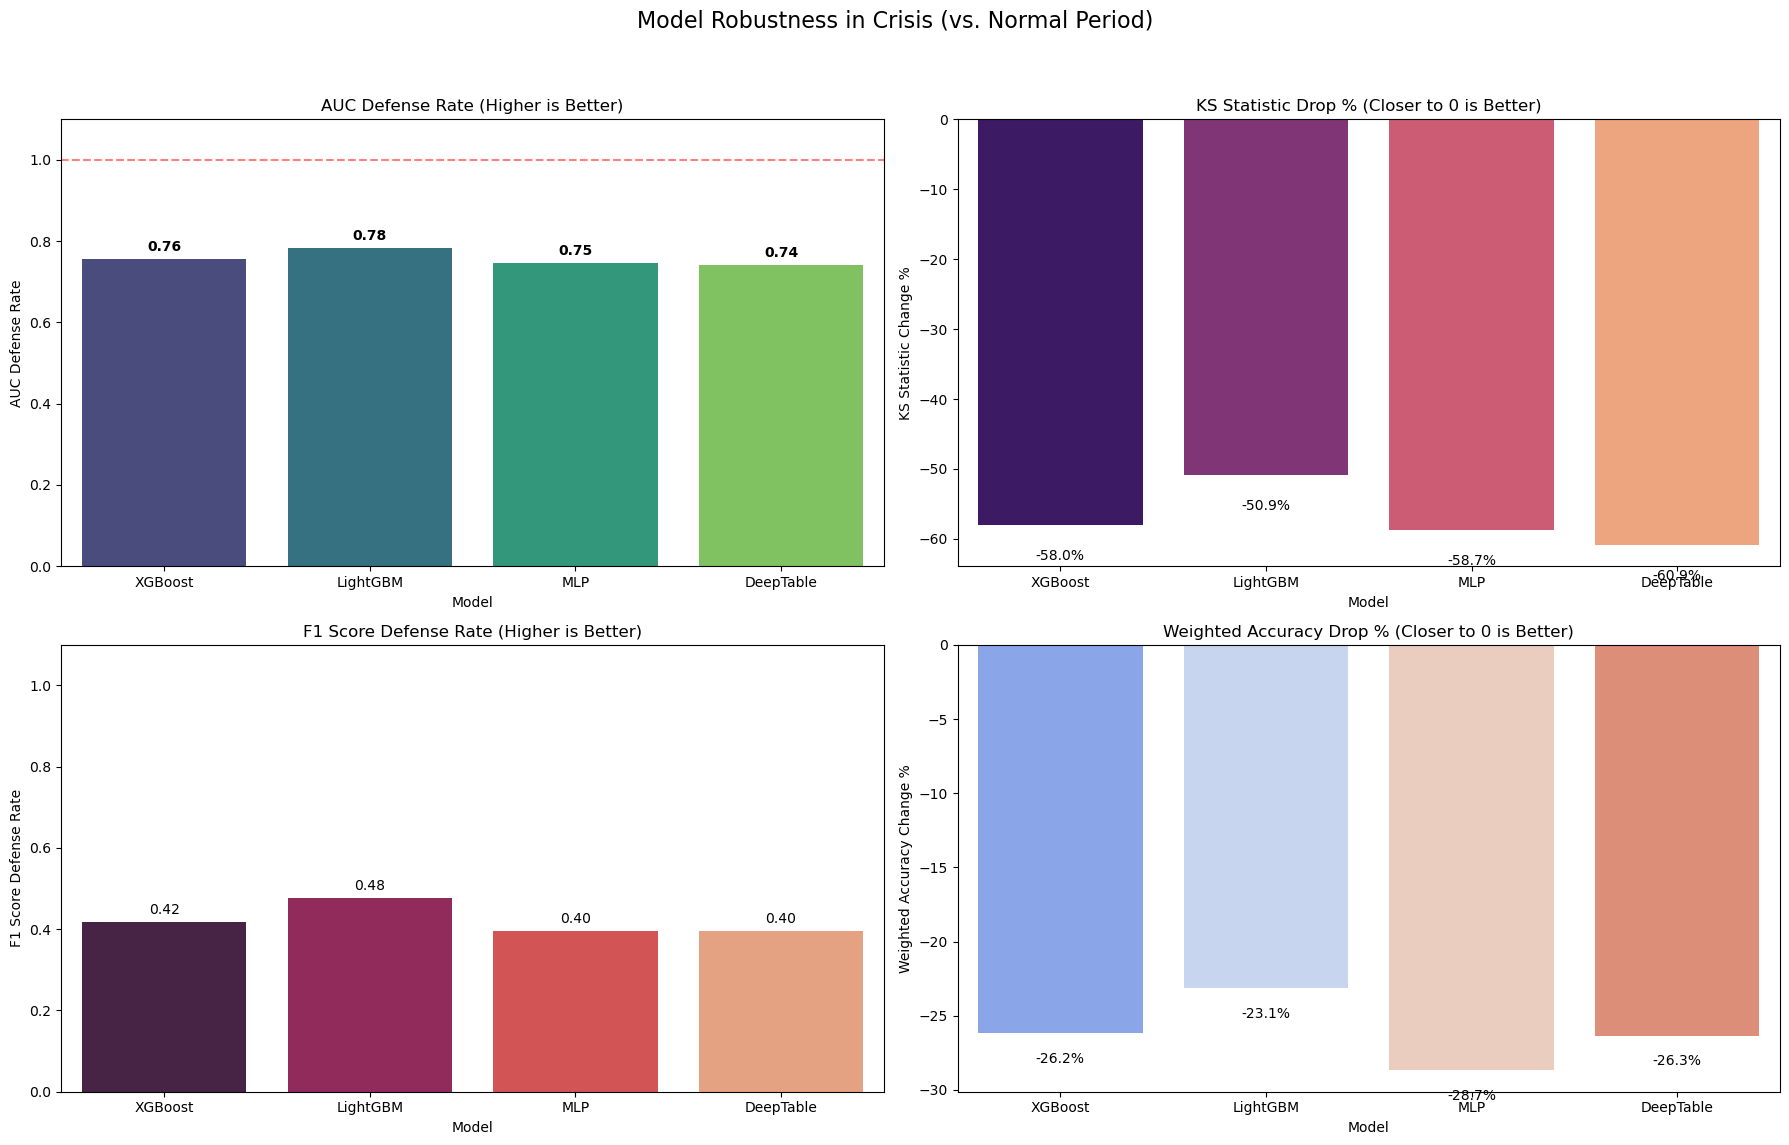

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 1. Aggregate Results from All Models
# ==============================================================================
# Ensure these DataFrames exist from previous steps
all_results = {
    "XGBoost": df_xgb_result,
    "LightGBM": df_lgb_result,
    "MLP": df_mlp_result,
    "DeepTable": df_dt_result
}

# Metrics to analyze
metrics_of_interest = ['AUC', 'KS Statistic', 'Weighted Accuracy', 'F1 Score']

# ==============================================================================
# 2. Calculate Defense Rate & Change Percentage
# ==============================================================================
robustness_data = []

for model_name, df in all_results.items():
    # Extract scores
    normal_scores = df.loc['Normal Period (Opt)']
    crisis_scores = df.loc['Crisis Period (Opt)']
    
    row = {'Model': model_name}
    
    for metric in metrics_of_interest:
        norm_val = normal_scores[metric]
        cris_val = crisis_scores[metric]
        
        # (1) Defense Rate: Crisis / Normal (1.0 is perfect retention)
        # "How much performance did we keep?"
        row[f'{metric} Defense Rate'] = cris_val / norm_val
        
        # (2) Change %: (Crisis - Normal) / Normal * 100
        # "How much performance did we lose?" (Negative values indicate drop)
        row[f'{metric} Change %'] = (cris_val - norm_val) / norm_val * 100
        
    robustness_data.append(row)

# Create Summary DataFrame
df_robustness = pd.DataFrame(robustness_data).set_index('Model')

print(">>> Model Robustness Summary (Defense Rates & % Changes)")
display(df_robustness)

# ==============================================================================
# 3. Visualization: Robustness Comparison
# ==============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Model Robustness in Crisis (vs. Normal Period)', fontsize=16)

# Plot 1: AUC Defense Rate
sns.barplot(x=df_robustness.index, y='AUC Defense Rate', data=df_robustness, ax=axes[0,0], palette='viridis')
axes[0,0].set_title('AUC Defense Rate (Higher is Better)')
axes[0,0].set_ylim(0, 1.1)
axes[0,0].axhline(1.0, color='red', linestyle='--', alpha=0.5, label='No Drop')
for i, v in enumerate(df_robustness['AUC Defense Rate']):
    axes[0,0].text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

# Plot 2: KS Statistic Change %
sns.barplot(x=df_robustness.index, y='KS Statistic Change %', data=df_robustness, ax=axes[0,1], palette='magma')
axes[0,1].set_title('KS Statistic Drop % (Closer to 0 is Better)')
for i, v in enumerate(df_robustness['KS Statistic Change %']):
    axes[0,1].text(i, v - 5 if v < 0 else v + 1, f"{v:.1f}%", ha='center', color='black')

# Plot 3: F1 Score Defense Rate
sns.barplot(x=df_robustness.index, y='F1 Score Defense Rate', data=df_robustness, ax=axes[1,0], palette='rocket')
axes[1,0].set_title('F1 Score Defense Rate (Higher is Better)')
axes[1,0].set_ylim(0, 1.1)
for i, v in enumerate(df_robustness['F1 Score Defense Rate']):
    axes[1,0].text(i, v + 0.02, f"{v:.2f}", ha='center')

# Plot 4: Weighted Accuracy Change %
sns.barplot(x=df_robustness.index, y='Weighted Accuracy Change %', data=df_robustness, ax=axes[1,1], palette='coolwarm')
axes[1,1].set_title('Weighted Accuracy Drop % (Closer to 0 is Better)')
for i, v in enumerate(df_robustness['Weighted Accuracy Change %']):
    axes[1,1].text(i, v - 2 if v < 0 else v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()